# Optimizing the NBA 2021-2022 schedule to reduce total travel distance

In [1]:
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as pl

In [2]:
# let's import and select the data we will need
# this corresponds to the NBA official schedule for the season 2021-2022
# downloaded from: https://www.basketball-reference.com/leagues/NBA_2022_games.html

# directory where the notebook is located
dir_path = os.path.dirname(os.path.realpath("__file__"))
# search for the csv files containing NBA data
for root, dirs, files in os.walk(os.path.join(dir_path,'data')):
    # loop over files
    for ifile,file in enumerate(files):
        if(file[-4:]=='.csv'):
            # if it's a csv file read it and concatenate to pd.dataframe
            if(ifile==0):
                data = pd.read_csv(os.path.join(dir_path,'data',file))
            else:
                data = pd.concat([data,pd.read_csv(os.path.join(dir_path,'data',file))])

# select only important info for our problem: game date, visitor team and home team
features = ['Date','Visitor/Neutral','Home/Neutral']
data = data[features]

print(data.head())
print('')
print(data.shape)

             Date       Visitor/Neutral            Home/Neutral
0  Tue Feb 1 2022  New Orleans Pelicans         Detroit Pistons
1  Tue Feb 1 2022    Washington Wizards         Milwaukee Bucks
2  Tue Feb 1 2022            Miami Heat         Toronto Raptors
3  Tue Feb 1 2022         Orlando Magic           Chicago Bulls
4  Tue Feb 1 2022        Denver Nuggets  Minnesota Timberwolves

(1289, 3)


In [3]:
# change date to datetime format
data['Date'] = pd.to_datetime(data.Date)

# and then sort games according to their date
data = data.sort_values(by='Date',ignore_index=True)

print(data.head(10))
print('')
print(data.tail(10))

        Date        Visitor/Neutral            Home/Neutral
0 2021-10-19          Brooklyn Nets         Milwaukee Bucks
1 2021-10-19  Golden State Warriors      Los Angeles Lakers
2 2021-10-20          Orlando Magic       San Antonio Spurs
3 2021-10-20         Denver Nuggets            Phoenix Suns
4 2021-10-20       Sacramento Kings  Portland Trail Blazers
5 2021-10-20  Oklahoma City Thunder               Utah Jazz
6 2021-10-20     Philadelphia 76ers    New Orleans Pelicans
7 2021-10-20        Houston Rockets  Minnesota Timberwolves
8 2021-10-20     Washington Wizards         Toronto Raptors
9 2021-10-20         Boston Celtics         New York Knicks

           Date         Visitor/Neutral            Home/Neutral
1279 2022-04-29         Milwaukee Bucks           Chicago Bulls
1280 2022-04-29       Memphis Grizzlies  Minnesota Timberwolves
1281 2022-04-29   Golden State Warriors          Denver Nuggets
1282 2022-04-30           Atlanta Hawks              Miami Heat
1283 2022-04-30    

In [4]:
# create team name list
teams = np.unique(data['Home/Neutral'])
teams

array(['Atlanta Hawks', 'Boston Celtics', 'Brooklyn Nets',
       'Charlotte Hornets', 'Chicago Bulls', 'Cleveland Cavaliers',
       'Dallas Mavericks', 'Denver Nuggets', 'Detroit Pistons',
       'Golden State Warriors', 'Houston Rockets', 'Indiana Pacers',
       'Los Angeles Clippers', 'Los Angeles Lakers', 'Memphis Grizzlies',
       'Miami Heat', 'Milwaukee Bucks', 'Minnesota Timberwolves',
       'New Orleans Pelicans', 'New York Knicks', 'Oklahoma City Thunder',
       'Orlando Magic', 'Philadelphia 76ers', 'Phoenix Suns',
       'Portland Trail Blazers', 'Sacramento Kings', 'San Antonio Spurs',
       'Toronto Raptors', 'Utah Jazz', 'Washington Wizards'], dtype=object)

In [5]:
# get GPS coordinates for each team
# First 1 or 2 words of the team name usually correspond to city name
# except for 'Golden State Warriors' (Oakland), 'Indiana Pacers' (Indianapolis),
# 'Minnesota Timberwolves' (Minneapolis), 'Washington Wizards' (Washington D.C.)
coordinates = {}
coordinates.update({'Atlanta':[33.76683680774191, -84.38455703927055]})
coordinates.update({'Boston':[42.360127856467784, -71.0592422429082]})
coordinates.update({'Brooklyn':[40.67829787116639, -73.94259609129293]})
coordinates.update({'Charlotte':[35.227885158895226, -80.8405727119913]})
coordinates.update({'Chicago':[41.8830227662743, -87.62631425232046]})
coordinates.update({'Cleveland':[41.50747533466491, -81.69627510740239]})
coordinates.update({'Dallas':[32.776899826782035, -96.797040016886]})
coordinates.update({'Denver':[39.73040196572831, -104.9650681776708]})
coordinates.update({'Detroit':[42.330036860548084, -83.05116757825724]})
coordinates.update({'Golden State':[37.804860888211394, -122.27039215604059]})
coordinates.update({'Houston':[29.763829926072063, -95.37430660329528]})
coordinates.update({'Indiana':[39.789868560888564, -86.14983542032077]})
coordinates.update({'Los Angeles':[34.05202448202419, -118.253835696503]})
coordinates.update({'Memphis':[35.10767015309829, -89.9764049188966]})
coordinates.update({'Miami':[25.782958390693423, -80.19444816963241]})
coordinates.update({'Milwaukee':[43.0357264792476, -87.90632550502528]})
coordinates.update({'Minnesota':[44.97875968223634, -93.27606002119525]})
coordinates.update({'New Orleans':[30.014265377514903, -90.0083834974915]})
coordinates.update({'New York':[40.752761272829595, -73.99330878506909]})
coordinates.update({'Oklahoma City':[35.470162542161766, -97.53699977673254]})
coordinates.update({'Orlando':[28.542428285147786, -81.38527108751903]})
coordinates.update({'Philadelphia':[39.95246653757103, -75.16294253591319]})
coordinates.update({'Phoenix':[33.44825801576274, -112.07152449100633]})
coordinates.update({'Portland':[45.532061160991866, -122.66682741510022]})
coordinates.update({'Sacramento':[38.58134514346413, -121.49188839485114]})
coordinates.update({'San Antonio':[29.434834821953654, -98.50398335334215]})
coordinates.update({'Toronto':[43.65448495546174, -79.38614358368551]})
coordinates.update({'Utah':[40.76953056468027, -111.90184129983932]})
coordinates.update({'Washington':[38.89847917642217, -77.02120725998178]})

#coordinates


In [6]:
def loc_team(team):
    """
    Find location according to team name
    """

    # we are looking for the 1st two words, this will contain city name
    match = re.match('([A-Z,a-z]+)\s([0-9,A-Z,a-z]+)', team)

    try:
        # first word corresponds to city name
        result = coordinates[match.group(1)]
    except:
        # or city name contains two words (ex: 'Los Angeles')
        result = coordinates[match.group(1)+' '+match.group(2)]

    return result

#for team in teams:
#    print(team,loc_team(team))

In [7]:
#conda install -c conda-forge haversine
import haversine as hs # this calculates the distance between two points, taking into account the curvature of the earth

def distance(team1,team2):
    """
    Calculate distance between two cities according to the team names
    """

    loc1 = loc_team(team1)
    loc2 = loc_team(team2)

    return hs.haversine(loc1,loc2) # distance in km

# test
distance('Charlotte Hornets','Los Angeles Clippers')

3404.9112504235322

In [8]:
# now we need to know what is the list of games for a particular team
# this will be important when we want to look at the location of the team in its previous game

def create_dict(data):

    # dictionnaries containing lists in the following format:
    dict_index_games = {} # {'Charlotte Hornets':{index in the dataframe: [game in the season (integer), home (True or False), opponent]}}
    dict_number_games = {} # {'Charlotte Hornets':{game in the season (integer): [index in the dataframe, home (True or False), opponent]}}
    
    # loop over teams
    for team in teams:
        # create entry for each team in the dictionnary
        dict_index_games.update({team:{}})
        dict_number_games.update({team:{}})

    # loop over each game
    for i,match in data.iterrows():
        away_team = match['Visitor/Neutral']
        home_team = match['Home/Neutral']

        dict_index_games[away_team].update({i:[len(dict_index_games[away_team])+1,False,home_team]})
        dict_index_games[home_team].update({i:[len(dict_index_games[home_team])+1,True,away_team]})

        dict_number_games[away_team].update({len(dict_number_games[away_team])+1:[i,False,home_team]})
        dict_number_games[home_team].update({len(dict_number_games[home_team])+1:[i,True,away_team]})
    
    return dict_index_games, dict_number_games

# tests
dict_index_games, dict_number_games = create_dict(data)

for i,item in enumerate(dict_index_games['Charlotte Hornets']):
    if(i<10):
        pass
        if(i>0):
            print(item,data['Date'][item],abs(data['Date'][item]-data['Date'][dict_number_games['Charlotte Hornets'][i][0]]).days,dict_index_games['Charlotte Hornets'][item])
        else:
            print(item,data['Date'][item],dict_index_games['Charlotte Hornets'][item])

print('')
for i,item in enumerate(dict_number_games['Charlotte Hornets']):
    if(i<10):
        pass
        print(item,dict_number_games['Charlotte Hornets'][item])


11 2021-10-20 00:00:00 [1, True, 'Indiana Pacers']
24 2021-10-22 00:00:00 2 [2, False, 'Cleveland Cavaliers']
38 2021-10-24 00:00:00 2 [3, False, 'Brooklyn Nets']
47 2021-10-25 00:00:00 1 [4, True, 'Boston Celtics']
62 2021-10-27 00:00:00 2 [5, False, 'Orlando Magic']
74 2021-10-29 00:00:00 2 [6, False, 'Miami Heat']
89 2021-10-31 00:00:00 2 [7, True, 'Portland Trail Blazers']
99 2021-11-01 00:00:00 1 [8, True, 'Cleveland Cavaliers']
109 2021-11-03 00:00:00 2 [9, False, 'Golden State Warriors']
126 2021-11-05 00:00:00 2 [10, False, 'Sacramento Kings']

1 [11, True, 'Indiana Pacers']
2 [24, False, 'Cleveland Cavaliers']
3 [38, False, 'Brooklyn Nets']
4 [47, True, 'Boston Celtics']
5 [62, False, 'Orlando Magic']
6 [74, False, 'Miami Heat']
7 [89, True, 'Portland Trail Blazers']
8 [99, True, 'Cleveland Cavaliers']
9 [109, False, 'Golden State Warriors']
10 [126, False, 'Sacramento Kings']


In [9]:
# we have the schedule for the whole season
# we have the approximate location for each game (this is the home_team location for each game)
# we have the list of games played by a particular team so that we can retrace their travels
# let's calculate the total travel for all teams

def calculate_km(data):

    # initialize kilometer counter
    total_km = 0

    # dictionnaries containing game list for each team
    dict_index_games, dict_number_games = create_dict(data)

    # loop over dataframe instances (games)
    for i,match in data.iterrows():
        # team names
        away_team = match['Visitor/Neutral']
        home_team = match['Home/Neutral']
        
        # find game number for each team
        away_ngame = dict_index_games[away_team][i][0] # format is {team: {i:[ngame,home,opponent]}}
        home_ngame = dict_index_games[home_team][i][0]

        # look for previous game information for away_team
        if(away_ngame>1):
            # use game number away_ngame to find previous game away_ngame-1
            away_prev_info = dict_number_games[away_team][away_ngame-1] # format is {team: {ngame:[i,home,opponent]}}
            
            if(away_prev_info[1]):
                # if previous game was at home for away_team
                # calculate distance between home of away_team, and home of home_team
                total_km += distance(away_team,home_team)
            else:
                # if previous game was away for away_team
                # calculate distance between home of opponent of the previous game, and home of home_team
                total_km += distance(away_prev_info[2],home_team)

        else:
            # if this is the away_team's 1st game, assume that the trip is from their home to away game
            # this is of course counted only for the away_team, the home_team is already at home for the game
            total_km += distance(away_team,home_team)

        # look for previous game information for home_team
        if(home_ngame>1):
            # use game number home_ngame to find previous game home_ngame-1
            home_prev_info = dict_number_games[home_team][home_ngame-1] # format is {team: {ngame:[i,home,opponent]}}

            if(home_prev_info[1]):
                # if previous game was at home for home_team
                # no travel
                pass
            else:
                # if previous game was away for home_team
                # calculate distance between home of opponent of the previous game, and home of home_team
                total_km += distance(home_prev_info[2],home_team)

    return total_km

# test
total_km = calculate_km(data)
print(f'Total kilometers for the 2021-2022 NBA season: {total_km:.2f} km')


Total kilometers for the 2021-2022 NBA season: 2174891.59 km


/var/folders/nd/znj7hrk57913sklcr76040880000gn/T/ipykernel_11809/4077716525.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/nd/znj7hrk57913sklcr76040880000gn/T/ipykernel_11809/4077716525.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/nd/znj7hrk57913sklcr76040880000gn/T/ipykernel_11809/4077716525.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/nd/znj7hrk57913sklcr76040880000gn/T/ipykernel

too many unsuccessful trials, optimization is stopped
too many unsuccessful trials, optimization is stopped
too many unsuccessful trials, optimization is stopped
too many unsuccessful trials, optimization is stopped


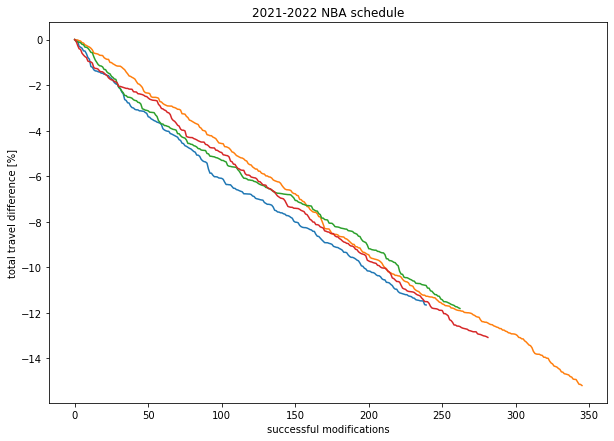

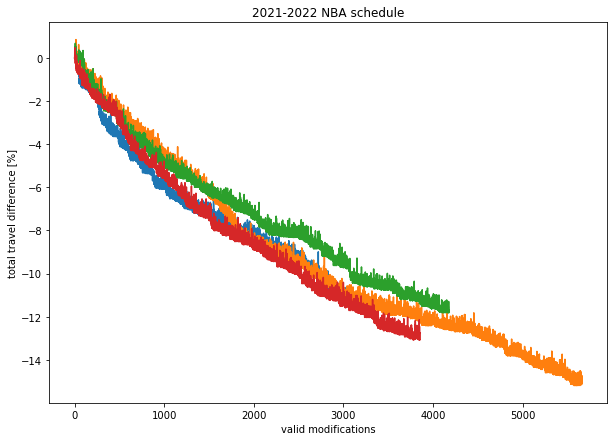

In [10]:
from joblib import Parallel, delayed

%matplotlib inline

# now we will try to change the official NBA 2021-2022 schedule
# in order to reduce the total kilometers required for travel

# for simplicity, we won't modify the game dates
# we will just randomly swap a game (away_team,home_team) with an other one
# until convergence

# official schedule km
official_total_km = calculate_km(data)

def optimize_schedule(list_total_km,list_total_all_km,new_data):
    """
    Function to optimize the official NBA schedule, we randomly swap games with
    the goal to reduce the total distance traveled during the whole season by all the teams
    we use a Markov chain Monte Carlo:
    random walk through all the different NBA schedules
    new schedules are accepted if only they reduce the total distance
    """

    # best km corresponds to last item in list_total_km
    best_total_km = list_total_km[-1] 

    # count unsuccessful iterations
    count_unsuccessful = 0

    # loop over individual modifications
    # max_iterations is an arbitrary number 
    # takes very long time to evaluate, successful modifications account only for 1% or less of all trials
    # 10 000 iterations take ~ 30 min to complete
    max_iterations = 150000
    for _ in range(max_iterations):

        if(count_unsuccessful>1000):
            print('too many unsuccessful trials, optimization is stopped')
            break

        count_unsuccessful += 1 # assume first that this trial is unsuccessful

        # randomly select index for swapping two games with each other
        rand1, rand2 = np.random.randint(0, len(data), size=2)

        # initialize trial dataframe
        trial_data = new_data.copy()
        # swap two games with index rand1 and rand2
        trial_data['Visitor/Neutral'][rand1],trial_data['Home/Neutral'][rand1] = new_data['Visitor/Neutral'][rand2],new_data['Home/Neutral'][rand2]
        trial_data['Visitor/Neutral'][rand2],trial_data['Home/Neutral'][rand2] = new_data['Visitor/Neutral'][rand1],new_data['Home/Neutral'][rand1]

        # the 1st constraint we will impose is that this new change
        # shouldn't make the same exact game happen twice in a row

        # the 2nd requirement we will impose is that there should be
        # at least 1 day between games for a particular team

        # we need the information about previous/next games for each team
        dict_index_games, dict_number_games = create_dict(trial_data)

        # we are checking if both new games are making a problem or not
        valid_schedule = True
        for irand in [rand1,rand2]:
            away_team = trial_data['Visitor/Neutral'][irand]
            home_team = trial_data['Home/Neutral'][irand]

            # game number for away_team and home_team
            away_ngame = dict_index_games[away_team][irand][0] # format is {team: {i:[ngame,home,opponent]}}
            home_ngame = dict_index_games[home_team][irand][0]

            if(away_ngame>1):
                away_prev_info = dict_number_games[away_team][away_ngame-1] # format is {team: {ngame:[i,home,opponent]}}

                if(away_prev_info[2]==home_team and away_prev_info[1]==dict_number_games[away_team][away_ngame][1]):
                    # if previous opponent is the same as for this game
                    # and if both games are played in the same location
                    # we reject this schedule
                    valid_schedule = False

                if(abs(trial_data['Date'][irand]-trial_data['Date'][away_prev_info[0]]).days < 1):
                    # if date between this game and previous one is less than 2 days
                    # we reject this schedule
                    valid_schedule = False

            if(home_ngame>1):
                home_prev_info = dict_number_games[home_team][home_ngame-1] # format is {team: {ngame:[i,home,opponent]}}

                if(home_prev_info[2]==away_team and home_prev_info[1]==dict_number_games[home_team][home_ngame][1]):
                    # if previous opponent is the same as for this game
                    # and if both games are played in the same location
                    # we reject this schedule
                    valid_schedule = False

                if(abs(trial_data['Date'][irand]-trial_data['Date'][home_prev_info[0]]).days < 1):
                    # if date between this game and previous one is less than 2 days
                    # we reject this schedule
                    valid_schedule = False

            if(away_ngame<len(dict_number_games[away_team])):
                away_next_info = dict_number_games[away_team][away_ngame+1] # format is {team: {ngame:[i,home,opponent]}}

                if(away_next_info[2]==home_team and away_next_info[1]==dict_number_games[away_team][away_ngame][1]):
                    # if next opponent is the same as for this game
                    # and if both games are played in the same location
                    # we reject this schedule
                    valid_schedule = False

                if(abs(trial_data['Date'][irand]-trial_data['Date'][away_next_info[0]]).days < 1):
                    # if date between this game and next one is less than 2 days
                    # we reject this schedule
                    valid_schedule = False

            if(home_ngame<len(dict_number_games[home_team])):
                home_next_info = dict_number_games[home_team][home_ngame+1] # format is {team: {ngame:[i,home,opponent]}}

                if(home_next_info[2]==away_team and home_next_info[1]==dict_number_games[home_team][home_ngame][1]):
                    # if next opponent is the same as for this game
                    # and if both games are played in the same location
                    # we reject this schedule
                    valid_schedule = False

                if(abs(trial_data['Date'][irand]-trial_data['Date'][home_next_info[0]]).days < 1):
                    # if date between this game and next one is less than 2 days
                    # we reject this schedule
                    valid_schedule = False

        if(valid_schedule):
            # trial schedule is accepted
            pass
        else:
            continue

        # let's calculate new total_km
        new_total_km = calculate_km(trial_data)

        list_total_all_km += [new_total_km]
        
        # is it worth keeping the change in the schedule or not?
        # check if total_km is improved, if yes record best_total_km and keep new schedule
        if(new_total_km<best_total_km):
            best_total_km = new_total_km
            new_data = trial_data.copy()
            list_total_km += [new_total_km]
            count_unsuccessful = 0 # reset counter for unsuccessful trials

    return [list_total_km, list_total_all_km, new_data]

# number of optimization loops
n_optimizations = 4

# are we starting from 0 or are we using a previously calculated optimization?
cold_start = True
if(cold_start):
    # start from the official NBA schedule
    # initalize dataframe with the official NBA schedule
    # new_data will record the best schedule we get during the modifications

    # [record successful modifications, record all valid modifications, save schedule]
    # [list_total_km, list_total_all_km, new_data]
    all_data = [[[official_total_km],[official_total_km], data]  for _ in range(n_optimizations)]

# for loop over optimizations
#for imod,(list_total_km,list_total_all_km,new_data) in enumerate(all_data):
#    print(f'\nset of modifications: {imod}')
#    all_data[imod][0],all_data[imod][1],all_data[imod][2] = optimize_schedule(list_total_km,list_total_all_km,new_data)

# calculate optimizations in parallel instead
all_data = Parallel(n_jobs=-1)(delayed(optimize_schedule)(*x) for x in all_data)

# plot showing the kilometers after each successful modifications
f,ax = pl.subplots(figsize=(10,7))
for list_total_km,_,_ in all_data:
    ax.plot((np.array(list_total_km)-official_total_km)/official_total_km*100)
ax.set(xlabel='successful modifications',ylabel='total travel difference [%]',title='2021-2022 NBA schedule')
pl.show()

# plot showing the kilometers after each valid modifications
f,ax = pl.subplots(figsize=(10,7))
for _,list_total_all_km,_ in all_data:
    ax.plot((np.array(list_total_all_km)-official_total_km)/official_total_km*100)
ax.set(xlabel='valid modifications',ylabel='total travel difference [%]',title='2021-2022 NBA schedule')
pl.show()

In [20]:
# display and find the best improvements
best_optimization = 0
for i in range(n_optimizations):
    current_optimization = (all_data[i][1][-1]-official_total_km)/official_total_km
    print(f'Improvement of {current_optimization}%')
    if(current_optimization<best_optimization):
        best_optimization = current_optimization
        ibest = i

# print best new optimized schedule
print('')
print(all_data[ibest][2].head(15))
print('')
print(all_data[ibest][2].tail(15))

Improvement of -0.11293408290545126%
Improvement of -0.14958226040527461%
Improvement of -0.1180707760935742%
Improvement of -0.12752252384271578%

         Date        Visitor/Neutral            Home/Neutral
0  2021-10-19  Oklahoma City Thunder  Portland Trail Blazers
1  2021-10-19          Orlando Magic           Atlanta Hawks
2  2021-10-20          Orlando Magic       San Antonio Spurs
3  2021-10-20         Denver Nuggets            Phoenix Suns
4  2021-10-20       Sacramento Kings  Portland Trail Blazers
5  2021-10-20  Oklahoma City Thunder               Utah Jazz
6  2021-10-20        Milwaukee Bucks           Atlanta Hawks
7  2021-10-20        Houston Rockets  Minnesota Timberwolves
8  2021-10-20     Washington Wizards         Toronto Raptors
9  2021-10-20        New York Knicks      Philadelphia 76ers
10 2021-10-20        Detroit Pistons    New Orleans Pelicans
11 2021-10-20         Indiana Pacers       Charlotte Hornets
12 2021-10-20    Cleveland Cavaliers       Memphis Grizzlie

In [21]:
# now look at the best new improved schedule for a particular team
dict_index_games, dict_number_games = create_dict(all_data[ibest][2])

for i,item in enumerate(dict_index_games['Charlotte Hornets']):
    if(i<150):
        pass
        if(i>0):
            print('days after previous game:',abs(data['Date'][item]-data['Date'][dict_number_games['Charlotte Hornets'][i][0]]).days,'; [ngame,home,opponent]:',dict_index_games['Charlotte Hornets'][item])
        else:
            print('[ngame,home,opponent]:',dict_index_games['Charlotte Hornets'][item])

# in general one can clearly see the following pattern: 
# games have been decided to optimize overall travel, 
# so that when playing away the team will try to play against nearby teams 
# (by example 'Golden State Warriors'->'Sacramento Kings'->'Los Angeles Clippers'->'Los Angeles Lakers')

[ngame,home,opponent]: [1, True, 'Indiana Pacers']
days after previous game: 2 ; [ngame,home,opponent]: [2, True, 'Cleveland Cavaliers']
days after previous game: 3 ; [ngame,home,opponent]: [3, True, 'Boston Celtics']
days after previous game: 2 ; [ngame,home,opponent]: [4, False, 'Orlando Magic']
days after previous game: 2 ; [ngame,home,opponent]: [5, False, 'Miami Heat']
days after previous game: 3 ; [ngame,home,opponent]: [6, False, 'Cleveland Cavaliers']
days after previous game: 1 ; [ngame,home,opponent]: [7, False, 'Milwaukee Bucks']
days after previous game: 1 ; [ngame,home,opponent]: [8, False, 'Golden State Warriors']
days after previous game: 2 ; [ngame,home,opponent]: [9, False, 'Sacramento Kings']
days after previous game: 2 ; [ngame,home,opponent]: [10, False, 'Los Angeles Clippers']
days after previous game: 1 ; [ngame,home,opponent]: [11, False, 'Los Angeles Lakers']
days after previous game: 2 ; [ngame,home,opponent]: [12, False, 'Memphis Grizzlies']
days after previou